In [5]:
model_name = 'conformer'

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam

from sklearn.model_selection import train_test_split

import numpy as np

from braindecode.models import EEGConformer

from tensorflow.keras import utils as np_utils
from torch.utils.data import DataLoader, TensorDataset, random_split

In [7]:
from processing_eeg_methods.data_utils import (
    convert_into_independent_channels,
    get_dataset_basic_info,
    get_input_data_path,
    standard_saving_path,
    write_model_info,
)
from processing_eeg_methods.data_loaders import load_data_labels_based_on_dataset
from processing_eeg_methods.share import datasets_basic_infos

subject_id = 19  # Only two things I should be able to change
dataset_name = "braincommand"  # Only two things I should be able to change

dataset_info = get_dataset_basic_info(datasets_basic_infos, dataset_name)

data_path = r"C:\Users\rosit\Documents\workprojects\bci_complete\EEG-Classifiers-Ensemble\Datasets\braincommand_dataset"

Load calibration and singleplayer with labels 0 and 1, respectively.

In [8]:
epochs_calibration, X_calibration, y_calibration_original = load_data_labels_based_on_dataset(
    dataset_info,
    subject_id,
    data_path,
    game_mode="calibration3",
)

epochs_singleplayer, X_singleplayer, y_singleplayer_original = load_data_labels_based_on_dataset(
    dataset_info,
    subject_id,
    data_path,
    game_mode="singleplayer",
)
y_calibration = [0] * len(y_calibration_original)
y_singleplayer = [1] * len(y_singleplayer_original)

X = np.concatenate((X_calibration, X_singleplayer), axis=0)
y = y_calibration + y_singleplayer

label 0 is 57
label 1 is 57
label 2 is 57
label 3 is 57
Not setting metadata
228 matching events found
Setting baseline interval to [0.0, 1.296] s
Applying baseline correction (mode: mean)
0 projection items activated
label 0 is 104
label 1 is 50
label 2 is 47
label 3 is 27
Not setting metadata
228 matching events found
Setting baseline interval to [0.0, 1.296] s
Applying baseline correction (mode: mean)
0 projection items activated


Load calibration from the clean .set file after EEGLAB manual rejection.

In [4]:
# import mne
# import numpy as np
# 
# _, X, y = load_data_labels_based_on_dataset(
#     dataset_info,
#     subject_id,
#     data_path,
#     game_mode="calibration3",
# )

label 0 is 57
label 1 is 57
label 2 is 57
label 3 is 57
Not setting metadata
228 matching events found
Setting baseline interval to [0.0, 1.296] s
Applying baseline correction (mode: mean)
0 projection items activated


In [9]:
# Split the data into 50% training and 50% temp (which will later be split into test and validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)

# Split the temp data into 50% test and 50% validation, resulting in 25% of the original data each
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(y_train)
num_classess = len(set(y_train))
print(f'There are {num_classess} unique classes in the dataset')

[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]
There are 2 unique classes in the dataset


In [10]:
kernels, chans, samples = 1, dataset_info["#_channels"], dataset_info["samples"]

# y_train = y_train - 1
# y_val = y_val - 1
# y_test = y_test - 1

# X_train      = X_train.reshape(X_train.shape[0], chans, samples)
# X_val   = X_val.reshape(X_val.shape[0], chans, samples)
# X_test       = X_test.reshape(X_test.shape[0], chans, samples)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Keep as integers

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

X_train shape: (228, 8, 325)
228 train samples
114 test samples


In [11]:
# Calculate the number of batches in train_loader
train_loader_size = len(train_loader)
print(f"Number of batches in train_loader: {train_loader_size}")

Number of batches in train_loader: 4


In [12]:
from collections import Counter

counts = Counter(y)

total_samples = sum(counts.values())

num_classes = len(counts)

class_weights = {class_label-1: total_samples / (num_classes * count) for class_label, count in counts.items()}

print(class_weights)

{-1: 1.0, 0: 1.0}


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

In [14]:
n_classes = dataset_info["#_class"]
classes = list(range(n_classes))

n_outputs = dataset_info["#_class"]
n_chans = dataset_info["#_channels"]
n_filters_time = 40
filter_time_length = 25
pool_time_length = 75
pool_time_stride = 15
drop_prob = 0.5
att_depth = 6
att_heads = 10
att_drop_prob = 0.5
final_fc_length = 640
return_features = False
n_times = dataset_info["samples"]
chs_info = None
input_window_seconds = None
sfreq = dataset_info["sample_rate"]
add_log_softmax = True

# Initialize the EEGConformer model
conformer = EEGConformer(
    n_outputs=n_outputs,
    n_chans=n_chans,
    n_filters_time=n_filters_time,
    filter_time_length=filter_time_length,
    pool_time_length=pool_time_length,
    pool_time_stride=pool_time_stride,
    drop_prob=drop_prob,
    att_depth=att_depth,
    att_heads=att_heads,
    att_drop_prob=att_drop_prob,
    final_fc_length=final_fc_length,
    return_features=return_features,
    n_times=n_times,
    chs_info=chs_info,
    input_window_seconds=input_window_seconds,
    sfreq=sfreq,
    add_log_softmax=add_log_softmax
)
conformer = conformer.to(device)

print(conformer)

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGConformer (EEGConformer)                                  [1, 8, 325]               [1, 4]                    --                        --
├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 8, 325]            [1, 16, 40]               --                        --
│    └─Sequential (shallownet): 2-1                          [1, 1, 8, 325]            [1, 40, 1, 16]            --                        --
│    │    └─Conv2d (0): 3-1                                  [1, 1, 8, 325]            [1, 40, 8, 301]           1,040                     [1, 25]
│    │    └─Conv2d (1): 3-2                                  [1, 40, 8, 301]           [1, 40, 1, 301]           12,840                    [8, 1]
│    │    └─BatchNorm2d (2): 3-3                             [1, 40, 1, 301]           [1, 40, 1, 301]           80              

Do this to find the right final_fc_length

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(conformer.parameters(), lr =  0.0002,betas  = [0.5, 0.999])

In [16]:
import torch

conformer.to(device)

# Create a dummy input with the correct shape and move it to the same device
dummy_input = torch.randn(kernels, chans, samples).to(device)  # Batch size

# Pass the dummy input through the model up to the transformer encoder
try:
    with torch.no_grad():  # Disable gradient calculation for inference
        x = torch.unsqueeze(dummy_input, dim=1)  # Add an extra dimension to match input shape
        x = conformer.patch_embedding(x)  # Pass through Patch Embedding
        x = conformer.transformer(x)  # Pass through Transformer Encoder
        
        # Get the shape after the transformer and calculate the new `final_fc_length`
        print(f"Output shape after transformer: {x.shape}")
        final_fc_length_calculated = x.shape[1] * x.shape[2]
        print(f"Calculated `final_fc_length`: {final_fc_length_calculated}")

except Exception as e:
    print("Error during partial forward pass:", str(e))

Output shape after transformer: torch.Size([1, 16, 40])
Calculated `final_fc_length`: 640


In [17]:
num_epochs = 250
## TRAIN
for epoch in range(num_epochs):
    conformer.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = conformer(X_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == y_batch).sum().item()
        total_predictions += y_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

## Validation
    conformer.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = conformer(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == y_batch).sum().item()
            total_predictions += y_batch.size(0)
    
    val_loss /= len(val_loader)
    val_accuracy = correct_predictions / total_predictions

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch [1/250], Loss: 1.3157, Accuracy: 0.3509
Validation Loss: 0.9900, Validation Accuracy: 0.5000
Epoch [2/250], Loss: 1.0842, Accuracy: 0.4825
Validation Loss: 0.8151, Validation Accuracy: 0.5000
Epoch [3/250], Loss: 0.9092, Accuracy: 0.4781
Validation Loss: 0.7446, Validation Accuracy: 0.5000
Epoch [4/250], Loss: 0.8592, Accuracy: 0.4605
Validation Loss: 0.7236, Validation Accuracy: 0.5000
Epoch [5/250], Loss: 0.7927, Accuracy: 0.4781
Validation Loss: 0.7146, Validation Accuracy: 0.5000
Epoch [6/250], Loss: 0.7893, Accuracy: 0.4956
Validation Loss: 0.7086, Validation Accuracy: 0.5000
Epoch [7/250], Loss: 0.7807, Accuracy: 0.4825
Validation Loss: 0.7225, Validation Accuracy: 0.5000
Epoch [8/250], Loss: 0.7899, Accuracy: 0.5307
Validation Loss: 0.7008, Validation Accuracy: 0.5000
Epoch [9/250], Loss: 0.7827, Accuracy: 0.5263
Validation Loss: 0.7188, Validation Accuracy: 0.5000
Epoch [10/250], Loss: 0.7711, Accuracy: 0.5307
Validation Loss: 0.7447, Validation Accuracy: 0.5000
Epoch [11

In [18]:
## TEST
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for X_batch, y_batch in test_loader:

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        outputs = conformer(X_batch)
        
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        correct_predictions += (predicted == y_batch).sum().item()
        total_predictions += y_batch.size(0)

test_loss /= len(test_loader)
test_accuracy = correct_predictions / total_predictions

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.1538
Test Accuracy: 0.8509


In [19]:
## TEST
import torch
import pandas as pd

# Initialize variables
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

# Define loss criterion
criterion = torch.nn.CrossEntropyLoss()

# Track loss and accuracy per batch
batch_results = []

# Disable gradient calculation for inference
with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
        # Move data to the appropriate device (GPU/CPU)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass through the model
        outputs = conformer(X_batch)
        
        # Calculate loss
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        correct_predictions += (predicted == y_batch).sum().item()
        total_predictions += y_batch.size(0)

        # Store individual batch results
        batch_results.append({
            'Batch': batch_idx + 1,
            'Loss': loss.item(),
            'Accuracy': (predicted == y_batch).sum().item() / y_batch.size(0)
        })

# Calculate average loss and overall accuracy
test_loss /= len(test_loader)
test_accuracy = correct_predictions / total_predictions

# Create DataFrame for detailed batch results
df_results = pd.DataFrame(batch_results)

# Print detailed report
print(f"{'='*60}")
print(f"{'Test Report':^60}")
print(f"{'='*60}")
print(f"Total Batches: {len(test_loader)}")
print(f"Average Test Loss: {test_loss:.4f}")
print(f"Overall Test Accuracy: {test_accuracy:.4f}")
print(f"{'='*60}")
print(f"\nBatch-wise Results:")
print(df_results.to_string(index=False))


                        Test Report                         
Total Batches: 2
Average Test Loss: 1.1538
Overall Test Accuracy: 0.8509

Batch-wise Results:
 Batch     Loss  Accuracy
     1 1.074396  0.859375
     2 1.233160  0.840000


                        Test Report                         
Total Batches: 2
Average Test Loss: 1.1538
Overall Test Accuracy: 0.8509

Batch-wise Results:
 Batch     Loss  Accuracy
     1 1.074396  0.859375
     2 1.233160  0.840000


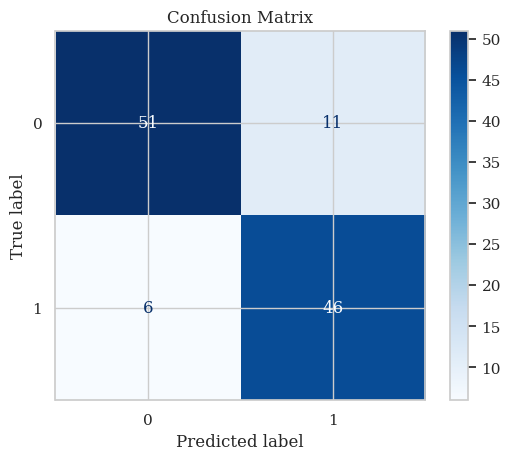

In [22]:
## TEST
import torch
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize variables
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
all_labels = []
all_predictions = []

# Define loss criterion
criterion = torch.nn.CrossEntropyLoss()

# Track loss and accuracy per batch
batch_results = []

# Disable gradient calculation for inference
with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
        # Move data to the appropriate device (GPU/CPU)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass through the model
        outputs = conformer(X_batch)
        
        # Calculate loss
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        correct_predictions += (predicted == y_batch).sum().item()
        total_predictions += y_batch.size(0)
        
        # Store labels and predictions for confusion matrix
        all_labels.extend(y_batch.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        # Store individual batch results
        batch_results.append({
            'Batch': batch_idx + 1,
            'Loss': loss.item(),
            'Accuracy': (predicted == y_batch).sum().item() / y_batch.size(0)
        })

# Calculate average loss and overall accuracy
test_loss /= len(test_loader)
test_accuracy = correct_predictions / total_predictions

# Create DataFrame for detailed batch results
df_results = pd.DataFrame(batch_results)

# Print detailed report
print(f"{'='*60}")
print(f"{'Test Report':^60}")
print(f"{'='*60}")
print(f"Total Batches: {len(test_loader)}")
print(f"Average Test Loss: {test_loss:.4f}")
print(f"Overall Test Accuracy: {test_accuracy:.4f}")
print(f"{'='*60}")
print(f"\nBatch-wise Results:")
print(df_results.to_string(index=False))

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
